<a href="https://colab.research.google.com/github/matheus-lima-o/Analises/blob/main/Analise_de_Dados_Data_SUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import plotly.express as px

In [2]:
pd.set_option('display.max_columns', None)
#retirar os valores em notação científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/arquivo data sus/resultado_censo.csv', sep=';', encoding='latin1')
df.tail()

,Codigo Munici­pio,Municipio,Ano,Mes,Conteudo,Total,LONGITUDE,LATITUDE,NU_Populacao
360584,522155,TURVELANDIA,2019,Jan,Valor aprovado,4007,-5.030.748,-17.850.952,4985
360585,522160,URUACU,2019,Jan,Valor aprovado,81305,-49.147.488,-1.452.022,42546
360586,522200,VIANOPOLIS,2019,Jan,Valor aprovado,32328,-4.851.347,-1.674.208,14956
360587,522205,VICENTINOPOLIS,2019,Jan,Valor aprovado,8498,-4.980.724,-17.732.662,8768
360588,530010,BRASILIA,2019,Jan,Valor aprovado,20192152,-47.887.905,-15.794.087,2817068


In [4]:
# Transformar 'Conteudo' em duas colunas: 'Quantidade Aprovada' e 'Valor Aprovado'
df_pivot = df.pivot_table(index=['Codigo Munici­pio', 'Municipio', 'Ano', 'Mes', 'LONGITUDE', 'LATITUDE', 'NU_Populacao'],
                          columns='Conteudo', values='Total', fill_value=0).reset_index()

# Renomear as colunas para melhor legibilidade
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns={'Quantidade aprovada': 'Quantidade Aprovada', 'Valor aprovado': 'Valor Aprovado'})

# Corrigir os valores das colunas "LONGITUDE" e "LATITUDE"
df_pivot['LONGITUDE'] = df_pivot['LONGITUDE'].str.replace('.', '').astype(float) / 1000000
df_pivot['LATITUDE'] = df_pivot['LATITUDE'].str.replace('.', '').astype(float) / 1000000

# Combinar 'Mes' e 'Ano' em uma única coluna 'Data'
df_pivot['Data'] = df_pivot['Mes'] + ' ' + df_pivot['Ano'].astype(str)

# Substituir os nomes dos meses em português por abreviações em inglês
month_translation = {
    'Jan': 'Jan', 'Fev': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'Mai': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Ago': 'Aug', 'Set': 'Sep', 'Out': 'Oct', 'Nov': 'Nov', 'Dez': 'Dec'
}
df_pivot['Data'] = df_pivot['Data'].replace(month_translation, regex=True)

# Converter a coluna 'Data' para o formato datetime
df_pivot['Data'] = pd.to_datetime(df_pivot['Data'], format='%b %Y').dt.strftime('%Y-%m-%d')

# Exibir as primeiras linhas do dataframe transformado
df_pivot.head()


,Codigo Munici­pio,Municipio,Ano,Mes,LONGITUDE,LATITUDE,NU_Populacao,Quantidade Aprovada,Valor Aprovado,Data
0,110001,ALTA FLORESTA D'OESTE,2019,Abr,-62.000,-1.194,21495,284,65419,2019-04-01
1,110001,ALTA FLORESTA D'OESTE,2019,Ago,-62.000,-1.194,21495,263,68974,2019-08-01
2,110001,ALTA FLORESTA D'OESTE,2019,Dez,-62.000,-1.194,21495,141,41883,2019-12-01
3,110001,ALTA FLORESTA D'OESTE,2019,Fev,-62.000,-1.194,21495,168,43317,2019-02-01
4,110001,ALTA FLORESTA D'OESTE,2019,Jan,-62.000,-1.194,21495,183,41393,2019-01-01


In [7]:
# Garantir que a coluna 'Data' esteja presente e formatada corretamente para análise
df_pivot['Data'] = pd.to_datetime(df_pivot['Data'])

# Verificando duplicatas, valores nulos, tipos de dados e anos presentes no conjunto de dados
duplicate_count = df_pivot.duplicated().sum()
null_count = df_pivot.isnull().sum().sum()
data_types = df_pivot.dtypes.unique()
years_present = df_pivot['Data'].dt.year.unique()

print('Quantidade de valores duplicados: ',df.duplicated().sum()) # Consistência
print('Quantidade de valores nulos: ',df.isnull().sum().sum()) # Completude
print('Os tipos de dados são: ',df.dtypes.unique()) # Conformidade
print('Anos presentes no dataset: ',df_pivot['Data'].dt.year.unique()) # Temporalidade

Quantidade de valores duplicados:  0
Quantidade de valores nulos:  0
Os tipos de dados são:  [dtype('int64') dtype('O')]
Anos presentes no dataset:  [2019 2020 2021 2022 2023]


In [8]:
descriptive_stats = df_pivot[['Quantidade Aprovada', 'Valor Aprovado']].describe()

descriptive_stats

,Quantidade Aprovada,Valor Aprovado
count,180295.000,180295.000
mean,11088.845,523010.673
std,70719.948,3268330.999
min,1.000,0.000
25%,123.000,10952.500
50%,559.000,34083.000
75%,2871.000,124230.500
max,3176900.000,159839143.000


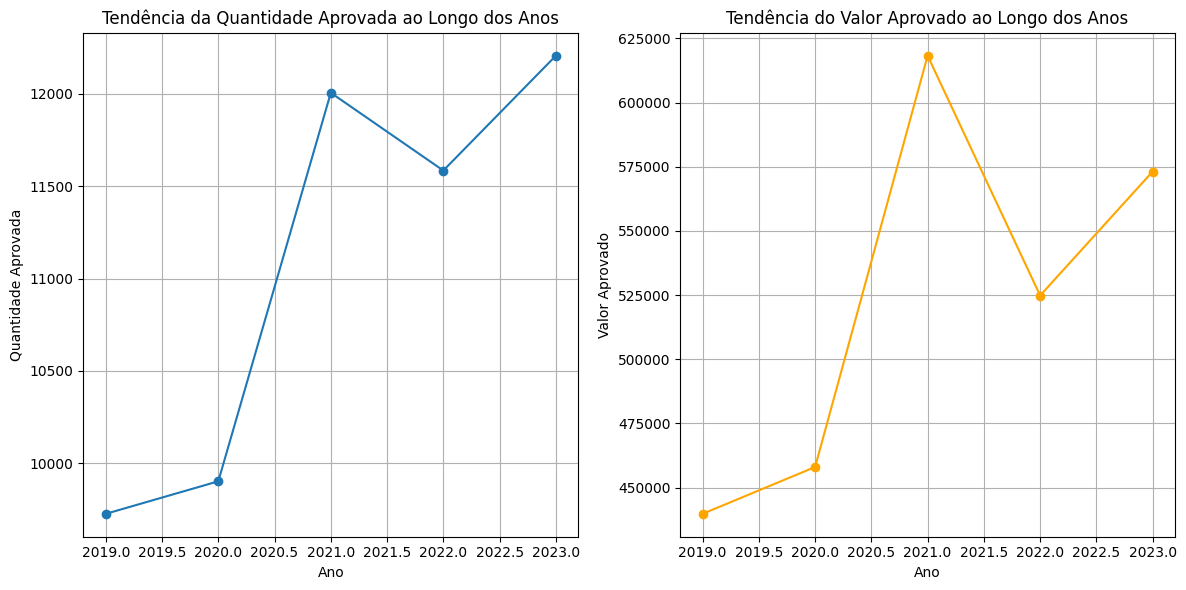

In [9]:
# Agrupe por ano e calcule a média de cada ano
df_pivot['Year'] = df_pivot['Data'].dt.year
yearly_trends = df_pivot.groupby('Year')[['Quantidade Aprovada', 'Valor Aprovado']].mean()

# Traçando as tendências ao longo do tempo
plt.figure(figsize=(12, 6))

# Plot para Quantidade Aprovada
plt.subplot(1, 2, 1)
plt.plot(yearly_trends.index, yearly_trends['Quantidade Aprovada'], marker='o')
plt.title('Tendência da Quantidade Aprovada ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade Aprovada')
plt.grid(True)

# Plot para Valor Aprovado
plt.subplot(1, 2, 2)
plt.plot(yearly_trends.index, yearly_trends['Valor Aprovado'], marker='o', color='orange')
plt.title('Tendência do Valor Aprovado ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Valor Aprovado')
plt.grid(True)

plt.tight_layout()
plt.show()

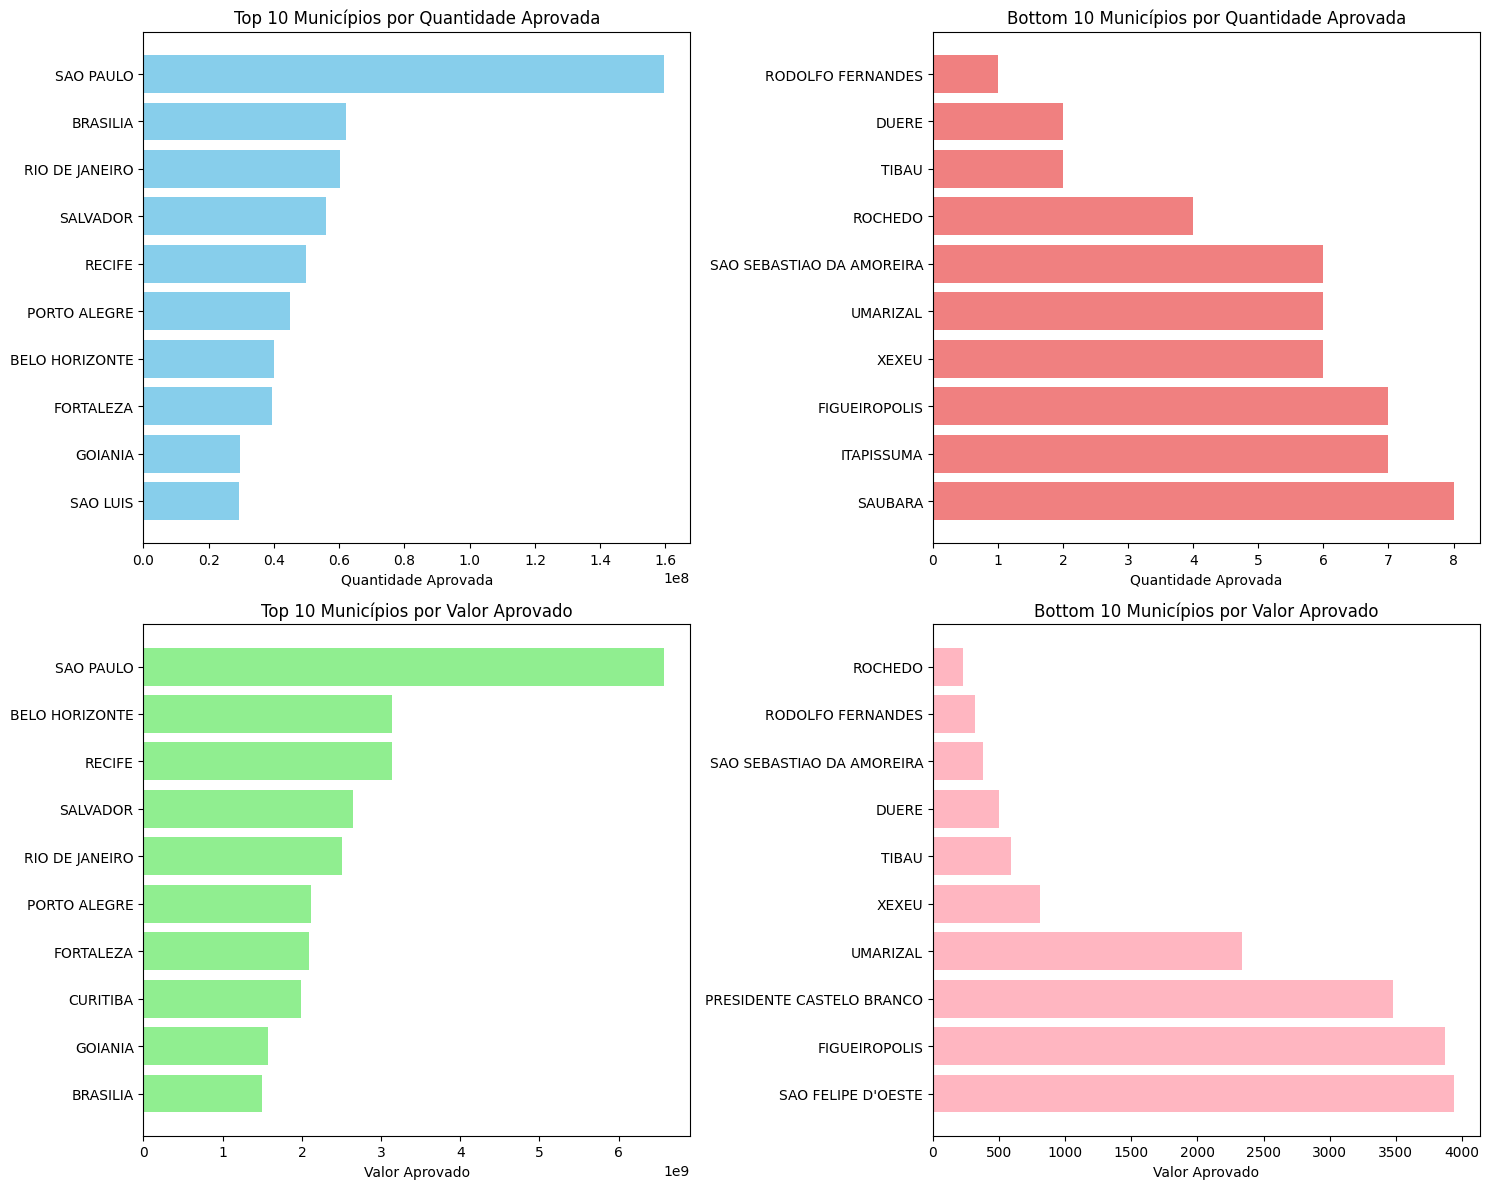

In [10]:
# Agrupar por município e calcular a soma de cada
municipality_stats = df_pivot.groupby('Municipio')[['Quantidade Aprovada', 'Valor Aprovado']].sum()

# Os 10 municípios com maiores quantidades e valores aprovados
top_quantidade = municipality_stats.nlargest(10, 'Quantidade Aprovada')
top_valor = municipality_stats.nlargest(10, 'Valor Aprovado')

# Os 10 municípios com menores quantidades e valores aprovados
bottom_quantidade = municipality_stats.nsmallest(10, 'Quantidade Aprovada')
bottom_valor = municipality_stats.nsmallest(10, 'Valor Aprovado')

# Traçando os municípios com mais e com menos
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# 10 Mais Quantidade Aprovada
axs[0, 0].barh(top_quantidade.index, top_quantidade['Quantidade Aprovada'], color='skyblue')
axs[0, 0].set_title('Top 10 Municípios por Quantidade Aprovada')
axs[0, 0].set_xlabel('Quantidade Aprovada')
axs[0, 0].invert_yaxis()

# 10 Menos Quantidade Aprovada
axs[0, 1].barh(bottom_quantidade.index, bottom_quantidade['Quantidade Aprovada'], color='lightcoral')
axs[0, 1].set_title(' Top 10 Municípios por menos Quantidade Aprovada')
axs[0, 1].set_xlabel('Quantidade Aprovada')
axs[0, 1].invert_yaxis()

# 10 Mais Valor Aprovado
axs[1, 0].barh(top_valor.index, top_valor['Valor Aprovado'], color='lightgreen')
axs[1, 0].set_title('Top 10 Municípios por Valor Aprovado')
axs[1, 0].set_xlabel('Valor Aprovado')
axs[1, 0].invert_yaxis()

# 10 Menos Valor Aprovado
axs[1, 1].barh(bottom_valor.index, bottom_valor['Valor Aprovado'], color='lightpink')
axs[1, 1].set_title(' Top 10 Municípios por menos Valor Aprovado')
axs[1, 1].set_xlabel('Valor Aprovado')
axs[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


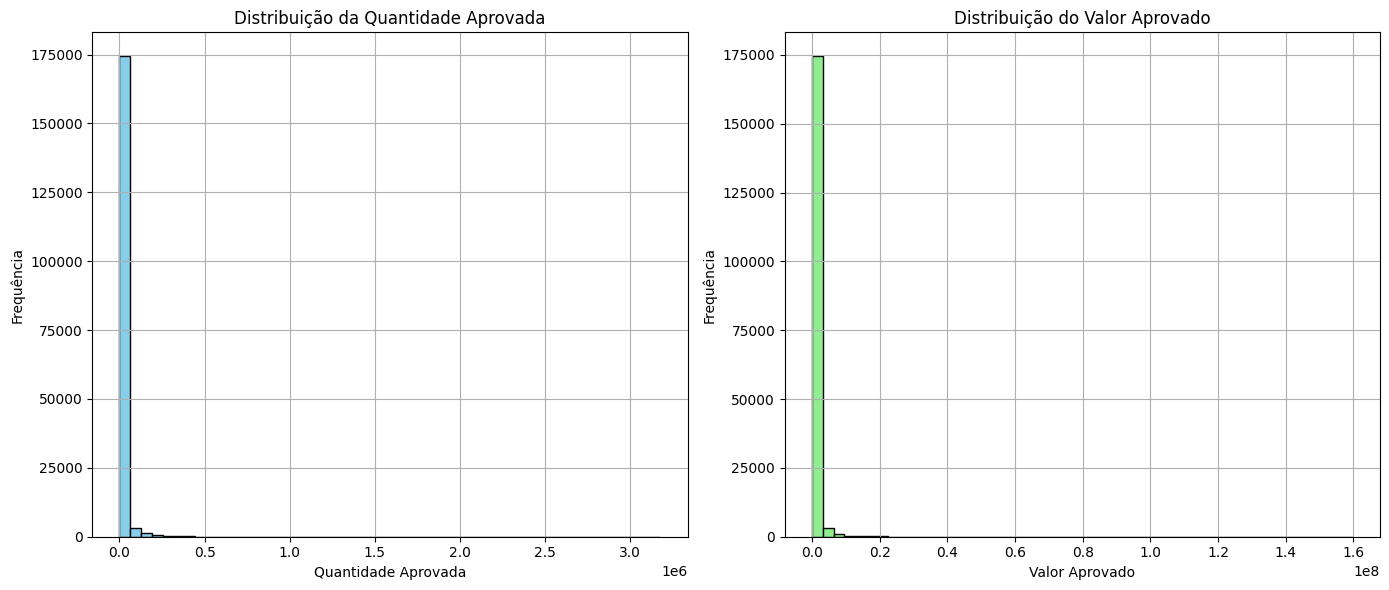

In [11]:
# Criando histogramas para 'Quantidade Aprovada' and 'Valor Aprovado'
plt.figure(figsize=(14, 6))

# Histograma para Quantidade Aprovada
plt.subplot(1, 2, 1)
plt.hist(df_pivot['Quantidade Aprovada'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição da Quantidade Aprovada')
plt.xlabel('Quantidade Aprovada')
plt.ylabel('Frequência')
plt.grid(True)

# Histograma para Valor Aprovado
plt.subplot(1, 2, 2)
plt.hist(df_pivot['Valor Aprovado'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribuição do Valor Aprovado')
plt.xlabel('Valor Aprovado')
plt.ylabel('Frequência')
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# Remodelar dados para modelo de regressão linear sklearn
X = df_pivot['Quantidade Aprovada'].values.reshape(-1, 1)
y = df_pivot['Valor Aprovado'].values

# Criando e ajustando o modelo
model = LinearRegression().fit(X, y)

# Obter o coeficiente, interceptação e valor de R ao quadrado
coefficient = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)


print('Coeficiente: ', coefficient)
print('Intercepto: ', intercept)
print('R2: ', r_squared)

Coeficiente:  44.3419106122745
Intercepto:  31310.081309079425
R2:  0.9205780362939681


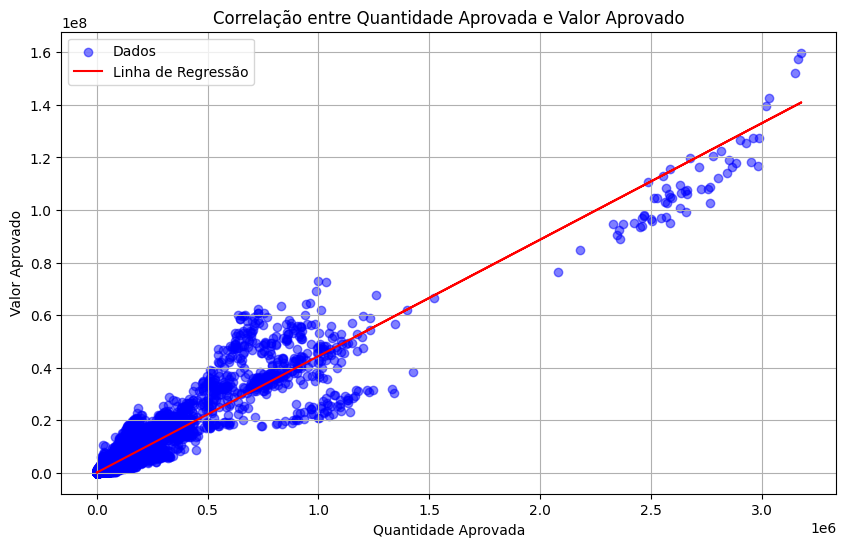

In [13]:
# Traçando a correlação com um gráfico de dispersão e a linha de regressão
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(df_pivot['Quantidade Aprovada'], df_pivot['Valor Aprovado'], alpha=0.5, color='blue', label='Dados')

# Linha de Regressão
plt.plot(df_pivot['Quantidade Aprovada'], model.predict(X), color='red', label='Linha de Regressão')

plt.title('Correlação entre Quantidade Aprovada e Valor Aprovado')
plt.xlabel('Quantidade Aprovada')
plt.ylabel('Valor Aprovado')
plt.legend()
plt.grid(True)
plt.show()

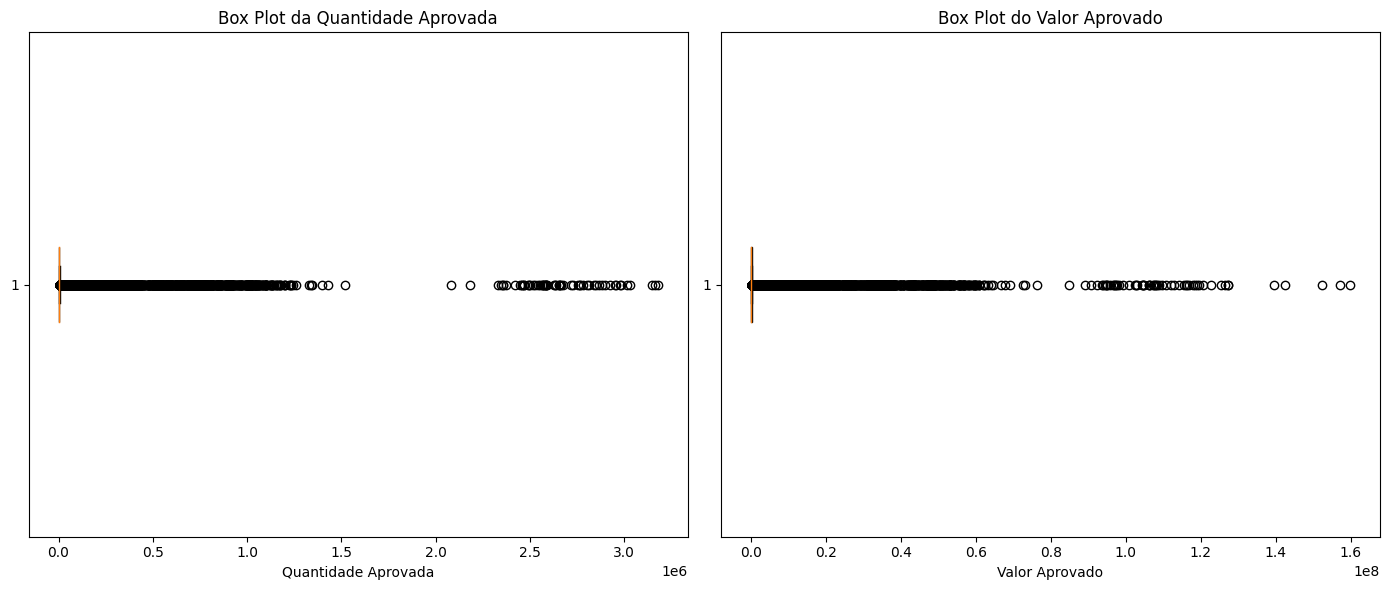

In [14]:
# Criando box plots para 'Quantidade Aprovada' and 'Valor Aprovado'
plt.figure(figsize=(14, 6))

# Box plot para Quantidade Aprovada
plt.subplot(1, 2, 1)
plt.boxplot(df_pivot['Quantidade Aprovada'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Box Plot da Quantidade Aprovada')
plt.xlabel('Quantidade Aprovada')

# Box plot para Valor Aprovado
plt.subplot(1, 2, 2)
plt.boxplot(df_pivot['Valor Aprovado'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Box Plot do Valor Aprovado')
plt.xlabel('Valor Aprovado')

plt.tight_layout()
plt.show()


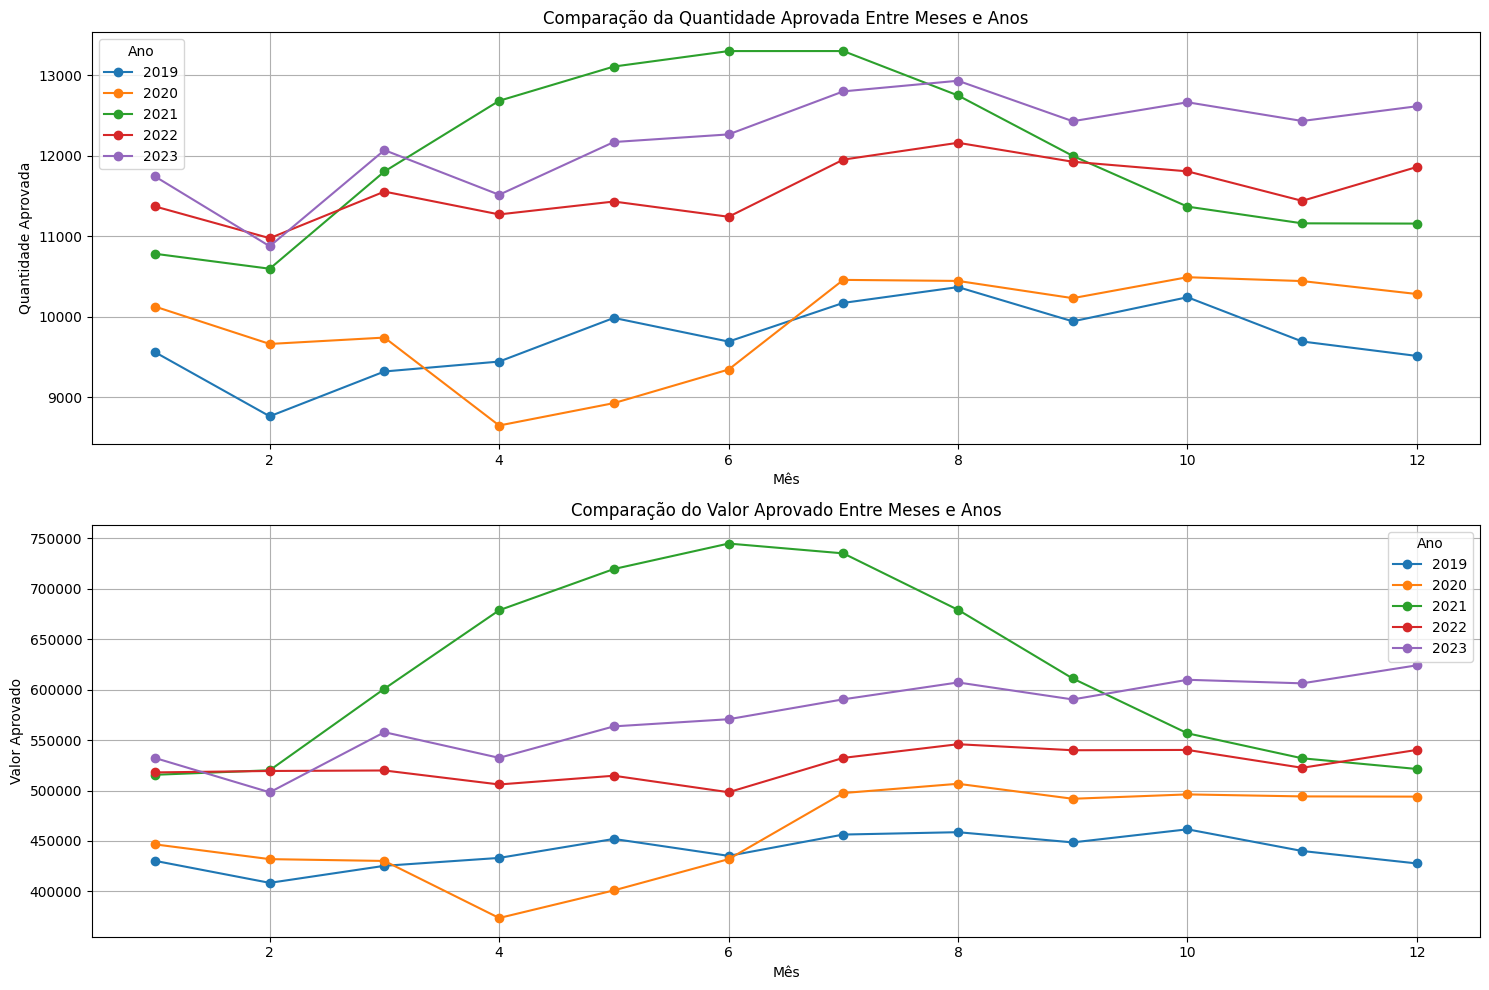

In [15]:
# Recalcular tendências mensais com estrutura correta
monthly_trends = df_pivot.groupby([df_pivot['Data'].dt.year, df_pivot['Data'].dt.month])[['Quantidade Aprovada', 'Valor Aprovado']].mean()
monthly_trends.index.names = ['Year', 'Month']

# Desempilhar o multi-índice para separar anos para comparação
monthly_trends_unstacked = monthly_trends.unstack(level=0)

# Traçando a comparação entre meses em anos diferentes
plt.figure(figsize=(15, 10))

# Plot para Quantidade Aprovada
plt.subplot(2, 1, 1)
for year in monthly_trends_unstacked['Quantidade Aprovada'].columns:
    plt.plot(monthly_trends_unstacked['Quantidade Aprovada'].index, monthly_trends_unstacked['Quantidade Aprovada'][year], marker='o', label=year)
plt.title('Comparação da Quantidade Aprovada Entre Meses e Anos')
plt.xlabel('Mês')
plt.ylabel('Quantidade Aprovada')
plt.legend(title='Ano')
plt.grid(True)

# Plot para Valor Aprovado
plt.subplot(2, 1, 2)
for year in monthly_trends_unstacked['Valor Aprovado'].columns:
    plt.plot(monthly_trends_unstacked['Valor Aprovado'].index, monthly_trends_unstacked['Valor Aprovado'][year], marker='o', label=year)
plt.title('Comparação do Valor Aprovado Entre Meses e Anos')
plt.xlabel('Mês')
plt.ylabel('Valor Aprovado')
plt.legend(title='Ano')
plt.grid(True)

plt.tight_layout()
plt.show()


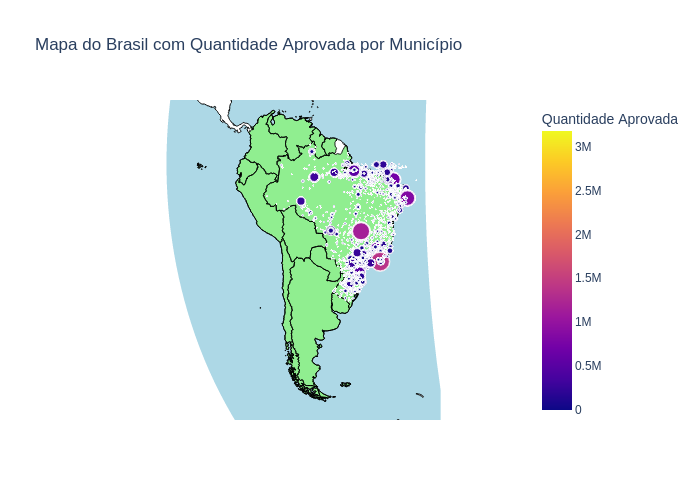

In [25]:
fig = px.scatter_geo(df_pivot,
                     lat='LATITUDE',
                     lon='LONGITUDE',
                     color='Quantidade Aprovada',
                     hover_name='Municipio',
                     size='Quantidade Aprovada',
                     projection="natural earth",
                     title="Mapa do Brasil com Quantidade Aprovada por Município")

# Ajustar o layout
fig.update_geos(
    visible=False,
    resolution=50,
    showcountries=True, countrycolor="Black",
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="LightGreen",
    showocean=True, oceancolor="LightBlue"
)

fig.update_layout(
    title='Mapa do Brasil com Quantidade Aprovada por Município',
    geo=dict(
        scope='south america',
    )
)

fig.show('png')

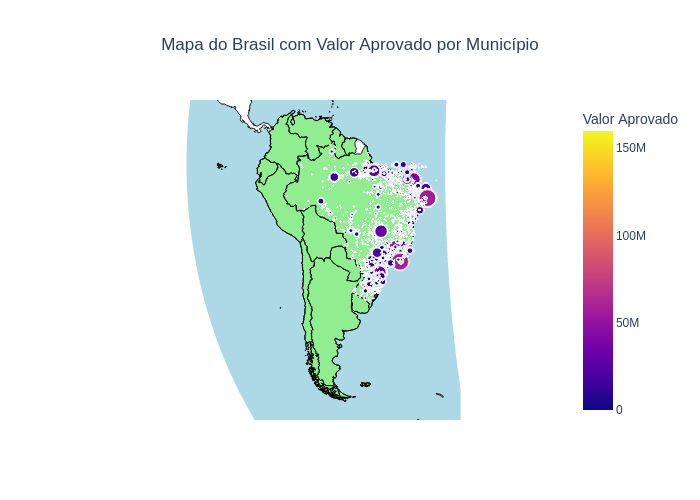

In [23]:
fig = px.scatter_geo(df_pivot,
                     lat='LATITUDE',
                     lon='LONGITUDE',
                     color='Valor Aprovado',
                     hover_name='Municipio',
                     size='Valor Aprovado',
                     projection="natural earth",
                     title="Mapa do Brasil com Valor Aprovado por Município")

# Ajustar o layout
fig.update_geos(
    visible=False,
    resolution=50,
    showcountries=True, countrycolor="Black",
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="LightGreen",
    showocean=True, oceancolor="LightBlue"
)

fig.update_layout(
    title='Mapa do Brasil com Valor Aprovado por Município',
    geo=dict(
        scope='south america',
    )
)

fig.show('png')